In [168]:
import statsmodels.formula.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
% matplotlib inline

## Read in the data, set index, re-code categoricals

In [150]:
data = pd.read_csv("spotify_data.csv")
data.index.name = "id"
key_map = {0:"C", 1:"Csharp", 2:"D", 3:"Dsharp", 4:"E", 5:"F", 6:"Fsharp", 7:"G", 8:"Gsharp", 9:"A", 10:"Asharp", 11:"B"}
data.key = data.key.apply(lambda x: key_map[x])
data = pd.concat([data, pd.get_dummies(data["key"], prefix="key")], axis=1)
Y = data["popularity"]
data.drop(["Unnamed: 0", "key", "release_date", "song", "artist"], axis=1, inplace=True)
data.head()
feature_names = list(data.columns)
feature_names.remove("popularity")

In [151]:
data.head()

,artist_followers,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,key_B,key_C,key_Csharp,key_D,key_Dsharp,key_E,key_F,key_Fsharp,key_G,key_Gsharp
id,,,,,,,,,,,,,,,,,,,,,
0,274175,0.024800,0.703,262320,0.914,0.000182,0.291,-15.277,0,0.0458,...,0,0,0,0,0,0,1,0,0,0
1,302270,0.000333,0.477,280213,0.859,0.000155,0.265,-8.625,1,0.0387,...,0,1,0,0,0,0,0,0,0,0
2,2078698,0.135000,0.525,314450,0.251,0.853000,0.329,-20.426,1,0.0333,...,0,0,0,0,0,0,0,0,0,0
3,1025185,0.004970,0.625,198267,0.951,0.000000,0.106,-5.209,1,0.0494,...,0,0,0,0,1,0,0,0,0,0
4,2805634,0.029700,0.670,222756,0.803,0.000000,0.345,-3.075,1,0.2740,...,0,0,0,0,0,0,0,0,1,0


In [152]:
data.columns

Index([u'artist_followers', u'acousticness', u'danceability', u'duration_ms',
       u'energy', u'instrumentalness', u'liveness', u'loudness', u'mode',
       u'speechiness', u'tempo', u'time_signature', u'valence', u'popularity',
       u'key_A', u'key_Asharp', u'key_B', u'key_C', u'key_Csharp', u'key_D',
       u'key_Dsharp', u'key_E', u'key_F', u'key_Fsharp', u'key_G',
       u'key_Gsharp'],
      dtype='object')

## Run simple linear regression with every feature to see pvalues, also plot the single variable predictions

In [204]:
simple_table = dict()
plt.ion()
for feature in feature_names:
    fitted = sm.ols(formula="popularity ~ " + feature, data=data).fit()
    plt.figure()
    plt.scatter(data[feature], data.popularity, alpha=.2, c='orange')
    plt.plot(data[feature], fitted.predict(data[feature]))
    plt.xlabel(feature)
    plt.ylabel("popularity")
    plt.title("Fitted regression line to training data")
    plt.savefig("figs/"+feature+"vs_popularity.png")
    plt.close()
    coeff = fitted.params[1]
    pvalue = fitted.pvalues[1]
    r2 = fitted.rsquared
    simple_table[feature] = [coeff, pvalue, round(r2, 4)]
    
    
simple_df = pd.DataFrame(data=simple_table).T
simple_df.columns = ["coeff", "pvalue", "r2"]
simple_df

,coeff,pvalue,r2
acousticness,-9.713727,4.685862e-42,0.0220
artist_followers,0.000004,7.981461e-223,0.1150
danceability,18.966368,1.681935e-40,0.0211
duration_ms,-0.000005,8.834781e-02,0.0003
energy,9.031304,4.592659e-22,0.0112
instrumentalness,-11.927539,2.789444e-29,0.0151
key_A,-1.995881,7.039827e-03,0.0009
key_Asharp,1.371000,1.490170e-01,0.0003
key_B,2.657466,2.948932e-03,0.0011
key_C,0.236437,7.313612e-01,0.0000


In [155]:
all_preds_table = pd.DataFrame(data=[fitted.params, fitted.pvalues]).T
all_preds_table.columns = ["coeff", "pvalue"]
all_preds_table

,coeff,pvalue
Intercept,40.155573,0.000000
key_Gsharp,1.529417,0.126268


In [156]:
pred_table = pd.DataFrame(data=dict(prediction=fitted.predict(data), popularity=data.popularity))

In [157]:
mse(pred_table.popularity, pred_table.prediction)

446.14699517789074

## Plot correlation coeffs vs popularity

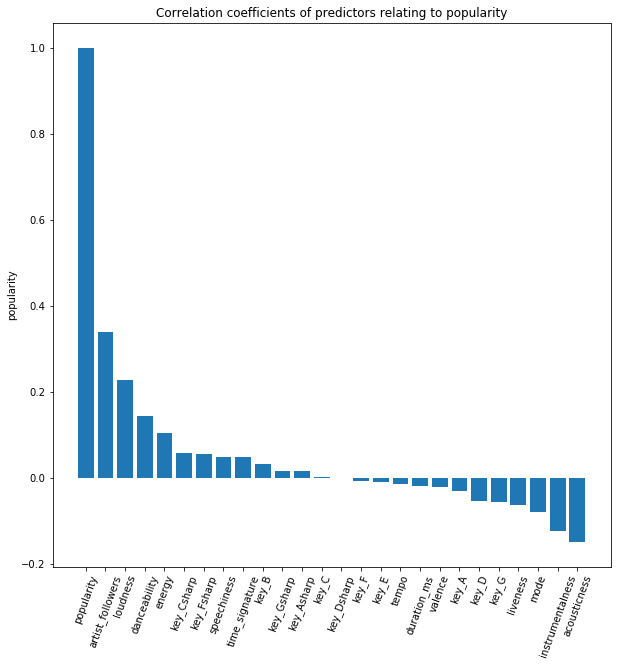

In [158]:
fig = plt.figure(figsize=(10, 10))
# plt.scatter(data.speechiness, data.popularity)
# plt.matshow(data.corr())
pop_corr = data.corr()["popularity"]
pop_corr = pop_corr.copy(deep=True)
pop_corr.sort_values(inplace=True, ascending=False)
plt.bar(range(len(pop_corr.index)), pop_corr.values)
xticks = plt.xticks(range(len(pop_corr.index)), pop_corr.index, rotation=70)
plt.ylabel("popularity")
t = plt.title("Correlation coefficients of predictors relating to popularity")
plt.savefig("figs/corr_bar.png")

## Fitting regression on top postive corr vars and top negative corr vars (individually)

In [159]:
tops = ["artist_followers", "loudness", "danceability", "energy", "key_Csharp"]
bottoms = ["acousticness", "instrumentalness", "mode", "liveness", "key_G"]

top_table = dict()
bot_table = dict()


# tops first
for t in tops:
    fitted = sm.ols(formula="popularity ~ " + t, data=data).fit()
    coeff, pval = fitted.params[1], fitted.pvalues[1]
    top_table[t] = [coeff, pval]
    
# now bottoms
for b in bottoms:
    fitted = sm.ols(formula="popularity ~ " + b, data=data).fit()
    coeff, pval = fitted.params[1], fitted.pvalues[1]
    bot_table[b] = [coeff, pval]
    
top_table = pd.DataFrame(data=top_table).T
top_table.columns = ["coeff", "pvalue"]
bot_table = pd.DataFrame(data=bot_table).T
bot_table.columns = ["coeff", "pvalue"]

In [160]:
top_table

,coeff,pvalue
artist_followers,0.000004,7.981461e-223
danceability,18.966368,1.681935e-40
energy,9.031304,4.592659e-22
key_Csharp,4.525527,5.162713e-08
loudness,1.077258,5.044759e-98


In [161]:
bot_table
pd.concat([top_table, bot_table])

,coeff,pvalue
artist_followers,0.000004,7.981461e-223
danceability,18.966368,1.681935e-40
energy,9.031304,4.592659e-22
key_Csharp,4.525527,5.162713e-08
loudness,1.077258,5.044759e-98
acousticness,-9.713727,4.685862e-42
instrumentalness,-11.927539,2.789444e-29
key_G,-3.543565,7.584568e-07
liveness,-7.913839,8.077932e-09
mode,-3.664818,5.461137e-13


## Running a multiple linear regression for each partition

In [189]:
# tops 
fitted_tops = sm.ols(formula="popularity ~ " + "+".join(tops), data=data).fit()
tops_multiple_regression = pd.DataFrame(data=[fitted_tops.params, fitted_tops.pvalues]).T
tops_multiple_regression.columns = ["coeff", "pvalue"]
print fitted_tops.fvalue

# cross validiation part
kf = KFold(n_splits=10)
X = data[feature_names]
y = data.popularity
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    fitted_tops = sm.ols(formula="popularity ~ " + "+".join(feature_names), data=pd.concat([X_train, y_train], axis = 1)).fit()
    print mse(fitted_tops.predict(X_train), y_train)
    
print zip(fitted_tops.predict(X_train), y_train)
    
    
# bottoms 
fitted_bots = sm.ols(formula="popularity ~ " + "+".join(bottoms), data=data).fit()
fitted_bots.summary()
bottom_multiple_regression = pd.DataFrame(data=[fitted_bots.params, fitted_bots.pvalues]).T
bottom_multiple_regression.columns = ["coeff", "pvalue"]
multiple_regression_parts = pd.concat([tops_multiple_regression, bottom_multiple_regression]).drop("Intercept")

multiple_regression_parts

318.854824878
368.244676205
367.112127456
366.426217074
366.694226058
366.970145063
367.626372384
364.214386684
365.721875782
363.564200689
359.16149948
[(30.860104464004433, 21), (34.674972681816151, 60), (33.852872235789768, 38), (42.296650604425899, 57), (50.73144359648439, 42), (24.796530253660084, 18), (34.050111266123295, 31), (43.948457412911885, 72), (39.210947119409894, 32), (40.25123811532422, 1), (34.951820294925341, 26), (32.387425449788616, 0), (68.757167489650186, 81), (33.63606526371899, 63), (38.796869409413375, 48), (25.004695364757559, 24), (35.528957511036786, 9), (33.268149267810053, 23), (47.435512842398779, 31), (44.269049678167761, 48), (40.892704662427221, 63), (38.828920828345019, 44), (34.027176695533079, 40), (39.459805929628331, 30), (47.325228213579607, 67), (25.243032357233979, 32), (42.108223904612601, 42), (35.605813941387211, 32), (33.59680079172724, 0), (40.270702591161729, 78), (33.165843424284368, 20), (40.664728550452253, 34), (40.326713738160329, 4

,coeff,pvalue
artist_followers,0.000003,6.870911e-176
loudness,1.236665,2.649535e-58
danceability,12.331949,3.108602e-20
energy,-11.872530,1.647739e-18
key_Csharp,2.112484,5.868507e-03
acousticness,-8.650842,2.140468e-33
instrumentalness,-10.795340,1.240683e-24
mode,-2.907516,8.362286e-09
liveness,-9.493790,1.904590e-12
key_G,-2.966781,2.537528e-05


## Explaining energy variable negative slope
The below corrrelation matrix shows the corelation between energy and loudness to be quite high at a value around .8. This reveals a tendency for loudness to increase as energy increases in a given song. So if the multiple linear regression is correct, loudness affects popularity of a song directly, so energy acts as a surrogate for loudness since in the simple linear regression it appeared that energy directly affects popularity. 

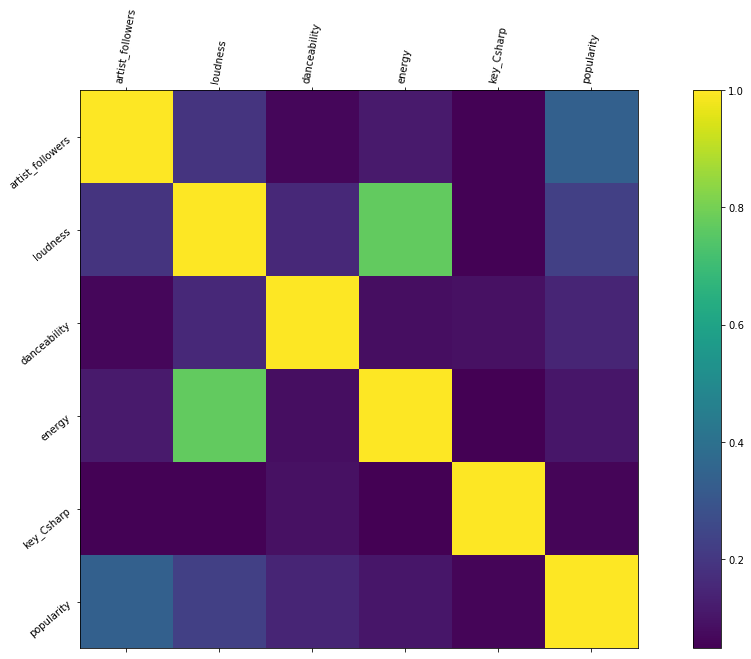

In [117]:
top_5_data = data[['artist_followers', 'loudness', 'danceability', 'energy', 'key_Csharp', 'popularity']]
bot_5_data = data[['acousticness', 'instrumentalness', 'mode', 'liveness', 'key_G', 'popularity']]

plt.figure(figsize=(20, 10))
cmax = plt.matshow(top_5_data.corr(), fignum=1, )
plt.colorbar(cmax)
xticks = plt.xticks(range(len(top_5_data.columns)), top_5_data.columns, rotation=80)
yticks = plt.yticks(range(len(top_5_data.columns)), top_5_data.columns, rotation=40)
plt.savefig("figs/top_5_corr_matrix.png")

# for the bottom 
# plt.figure(figsize=(20, 10))
# cmax = plt.matshow(bot_5_data.corr(), fignum=2)
# plt.colorbar(cmax)
# xticks = plt.xticks(range(len(bot_5_data.columns)), bot_5_data.columns, rotation=80)
# yticks = plt.yticks(range(len(bot_5_data.columns)), bot_5_data.columns, rotation=40)
# plt.savefig("figs/bot_5_corr_matrix.png")


In [118]:
top_5_data.corr()

,artist_followers,loudness,danceability,energy,key_Csharp,popularity
artist_followers,1.000000,0.191707,0.064928,0.115616,0.054408,0.339101
loudness,0.191707,1.000000,0.155469,0.769402,0.052415,0.227441
danceability,0.064928,0.155469,1.000000,0.083335,0.090226,0.145362
energy,0.115616,0.769402,0.083335,1.000000,0.047370,0.105623
key_Csharp,0.054408,0.052415,0.090226,0.047370,1.000000,0.059675
popularity,0.339101,0.227441,0.145362,0.105623,0.059675,1.000000


# Logistic Regression

In [246]:
threshold = 50 # If a song is 50 or above, it would be popular.
popularity = data['popularity']
tops = ["artist_followers", "loudness", "danceability", "energy", "key_Csharp"]
bottoms = ["acousticness", "instrumentalness", "mode", "liveness", "key_G"]

In [247]:
# Create binary output for popularity.
is_popular = []
for p in popularity:
    if p >= threshold:
        is_popular.append(1)
    else:
        is_popular.append(0)

data['is_popular'] = is_popular

In [251]:
# Run logistic regression.
model = sm.logit('is_popular ~ ' + '+'.join(tops) , data=data).fit(disp=False)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                 8315
Model:                          Logit   Df Residuals:                     8309
Method:                           MLE   Df Model:                            5
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.1024
Time:                        17:07:14   Log-Likelihood:                -4872.7
converged:                       True   LL-Null:                       -5428.9
                                        LLR p-value:                2.816e-238
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3622      0.201      1.799      0.072      -0.032       0.757
artist_followers  3.753e-07   1.83e-08     20.483      0.000    3.39e-07    4.11e-07
loudness             0.1334 

In [256]:
predictions = model.predict()
yhat = []

for p in predictions:
    if p*100 >= threshold:
        yhat.append(1)
    else:
        yhat.append(0)

tn, fp, fn, tp = confusion_matrix(is_popular, yhat).ravel()
pred = {'Predicted: Not Popular' : [tn, fn], 'Predicted: Popular' : [fp, tp]}
cf = pd.DataFrame(pred, index=['Actual: Not Popular', 'Actual: Popular'])
cf

,Predicted: Not Popular,Predicted: Popular
Actual: Not Popular,4975,354
Actual: Popular,2117,869


In [257]:
print("Accuracy is:", (tp+tn)/(tp+fp+fn+tn))

Accuracy is: 0.702826217679


# K-Fold CV

In [259]:
train_acc = []
test_acc = []

for i in range(0, 10):
    #Divide into equal subsets.
    kf = np.array_split(data, 10)
    
    #Create the training and test sets.
    test = kf[i]
    del kf[i]
    train = pd.concat(kf)
    
    #Fit a logistic regression.
    model = sm.logit('is_popular ~ ' + '+'.join(tops), data=train).fit(disp=False)
    p_train = model.predict()
    p_test = model.predict(test)
    
    yhat_train = []
    yhat_test = []
    
    for ptr in p_train:
        if ptr*100 > 50:
            yhat_train.append(1)
        else:
            yhat_train.append(0)
    
    for pte in p_test:
        if pte*100 > 50:
            yhat_test.append(1)
        else:
            yhat_test.append(0)
            
    tr_tn, tr_fp, tr_fn, tr_tp = confusion_matrix(train['is_popular'], yhat_train).ravel()
    te_tn, te_fp, te_fn, te_tp = confusion_matrix(test['is_popular'], yhat_test).ravel()

    train_acc.append((tr_tn+tr_tp)/(tr_tn+tr_fp+tr_fn+tr_tp))
    test_acc.append((te_tn+te_tp)/(te_tn+te_fp+te_fn+te_tp))

In [260]:
acc_table = pd.DataFrame({'Training Accuracy' : train_acc, 'Test Accuracy' : test_acc})
for x in range(0, len(acc_table)):
    acc_table = acc_table.rename({x: "Fold " + str(x+1)})
acc_table

,Test Accuracy,Training Accuracy
Fold 1,0.710337,0.702793
Fold 2,0.721154,0.700521
Fold 3,0.713942,0.701056
Fold 4,0.703125,0.702125
Fold 5,0.710337,0.702258
Fold 6,0.687124,0.704971
Fold 7,0.711191,0.702432
Fold 8,0.702768,0.702833
Fold 9,0.681107,0.705505
Fold 10,0.679904,0.705772
